In [1]:
%matplotlib inline

import collections
import glob
import json
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
seaborn.set_style("whitegrid")

In [2]:
base_dirpath = "/home/ubuntu/experiments/procgen_001"

In [3]:
def recursive_underscore_join_list(lst):
    result = ""
    for i, item in enumerate(lst):
        append = "_"
        if isinstance(item, list):
            item = recursive_underscore_join_list(item)
            append = "__"
        else:
            item = str(item)
        result += item
        if i < len(lst) - 1:
            result += append
    return result

def flatten_string_key_dict(d):
    result = dict()
    for k, v in d.items():
        if isinstance(v, dict):
            v = flatten_string_key_dict(v)
            for kk, vv in v.items():
                flat_key = f"{k}_{kk}"
                if isinstance(vv, list):
                    vv = recursive_underscore_join_list(vv)
                result[flat_key] = vv
        elif isinstance(v, list):
            result[k] = recursive_underscore_join_list(v)
        else:
            result[k] = v
    return result

def load_params_as_dataframe(filepath):
    with open(filepath, "r") as infile:
        params = json.load(infile)
        params = flatten_string_key_dict(params)
        return pd.DataFrame(params, index=[0])

def extract_relevant_info_from_row(row):
    info = dict()
    info["episode_reward_mean"] = row["episode_reward_mean"]
    if "evaluation" in row:
        info["evaluation_episode_reward_mean"] = row["evaluation"]["episode_reward_mean"]
    return info

def load_results_as_dataframe(filepath):
    data = []
    with open(filepath, "r") as infile:
        for row in infile:
            parsed = json.loads(row)
            parsed = extract_relevant_info_from_row(parsed)
            data.append(parsed)
    return pd.DataFrame(data)

class Run:
    def __init__(self, params, results):
        self.params = params
        self.results = results
        
    def as_row(self):
        """Returns a representation / summary of this run that can be used as a single row."""
        row = self.params.copy()
        if "evaluation_episode_reward_mean" in self.results:
            row["evaluation_episode_reward_mean"] = list(self.results["evaluation_episode_reward_mean"].dropna())[-1]
        return row
        
    def __len__(self):
        return len(self.results)
    
    @property
    def env(self):
        return self.params["env_config_env_name"].values[0]
    
    @classmethod
    def from_filepaths(cls, params_filepath, results_filepath, min_num_iter=300):
        assert os.path.exists(params_filepath)
        assert os.path.exists(results_filepath)
        params = load_params_as_dataframe(params_filepath)
        results = load_results_as_dataframe(results_filepath)
        if len(results) < min_num_iter:
            return None
        return cls(params, results)

In [4]:
test_filepath = "/home/ubuntu/experiments/procgen_001/chaser/chaser_itr_0_lr_sch_0_0.0005_num_sgd_iter_2_sgd_minibatch_size_814_num_envs_74_rollout_length_55_random_translate_ent_sch_0_0.01_gae_lambda_0.98_num_filters_32_64_64_dropout_0.05_drac_weight_0.1/custom_DataAugmentingPPOTrainer_custom_procgen_env_wrapper_15_2020-10-12_08-58-00qyiqv7qo/"
params_filepath = os.path.join(test_filepath, "params.json")
result_filepath = os.path.join(test_filepath, "result.json")

In [5]:
r = Run.from_filepaths(params_filepath, result_filepath)
print(r)

In [6]:
r.params.keys()

Index(['batch_mode', 'callbacks', 'clip_actions', 'clip_param', 'clip_rewards',
       'compress_observations', 'entropy_coeff', 'entropy_coeff_schedule',
       'env', 'env_config_center_agent', 'env_config_distribution_mode',
       'env_config_env_name', 'env_config_env_wrapper_options_frame_stack',
       'env_config_env_wrapper_options_frame_stack_options_k',
       'env_config_env_wrapper_options_grayscale',
       'env_config_env_wrapper_options_mixed_grayscale_color',
       'env_config_env_wrapper_options_mixed_grayscale_color_options_num_prev_frames',
       'env_config_env_wrapper_options_normalize_reward',
       'env_config_num_levels', 'env_config_paint_vel_info',
       'env_config_start_level', 'env_config_use_generated_assets',
       'env_config_use_sequential_levels',
       'evaluation_config_env_config_env_wrapper_options_normalize_reward',
       'evaluation_config_env_config_num_levels', 'evaluation_interval',
       'evaluation_num_episodes', 'evaluation_num_wor

In [7]:
runs = []
for root, dirs, filenames in os.walk(base_dirpath):
    if "result.json" in filenames and "params.json" in filenames:
        params_filepath = os.path.join(root, "params.json")
        results_filepath = os.path.join(root, "result.json")
        run = Run.from_filepaths(params_filepath, results_filepath)
        if run is not None:
            runs.append(run)
print(len(runs))

452


In [8]:
ENV_NAMES = list(set(r.env for r in runs))
print(ENV_NAMES)

['coinrun', 'jumper', 'maze', 'climber', 'miner', 'bossfight', 'caveflyer', 'leaper', 'dodgeball', 'plunder', 'starpilot', 'fruitbot', 'heist', 'ninja', 'bigfish', 'chaser']


In [9]:
EASY_GAME_RANGES = {
    'coinrun': [0, 5, 10],
    'starpilot': [0, 2.5, 64],
    'caveflyer': [0, 3.5, 12],
    'dodgeball': [0, 1.5, 19],
    'fruitbot': [-12, -1.5, 32.4],
    'chaser': [0, .5, 13],
    'miner': [0, 1.5, 13],
    'jumper': [0, 1, 10],
    'leaper': [0, 1.5, 10],
    'maze': [0, 5, 10],
    'bigfish': [0, 1, 40],
    'heist': [0, 3.5, 10],
    'climber': [0, 2, 12.6],
    'plunder': [0, 4.5, 30],
    'ninja': [0, 3.5, 10],
    'bossfight': [0, .5, 13],
    'caterpillar': [0, 8.25, 24],
    'gemjourney': [0, 1.1, 16],
    'hovercraft': [0, 0.2, 18],
    'safezone': [0, 0.2, 10],
}

# Plot per-run performance

In [10]:
def plot_run(run, ax, key, label):
    y = run.results[key]
    x = range(len(y))
    ax.plot(x, y, alpha=0.8, label=label)
    ax.set_title(run.env)
    if label is not None:
        ax.legend()

def plot_runs(runs, key="episode_reward_mean", label=None, make_figure=True):
    if make_figure:
        fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    else:
        fig = plt.gcf()
        axs = fig.get_axes()
        axs = np.reshape(axs, (4, 4))
    for run in runs:
        ax_index = ENV_NAMES.index(run.env)
        ax_row = ax_index // 4
        ax_col = ax_index % 4
        plot_run(run, axs[ax_row, ax_col], key, label=label)

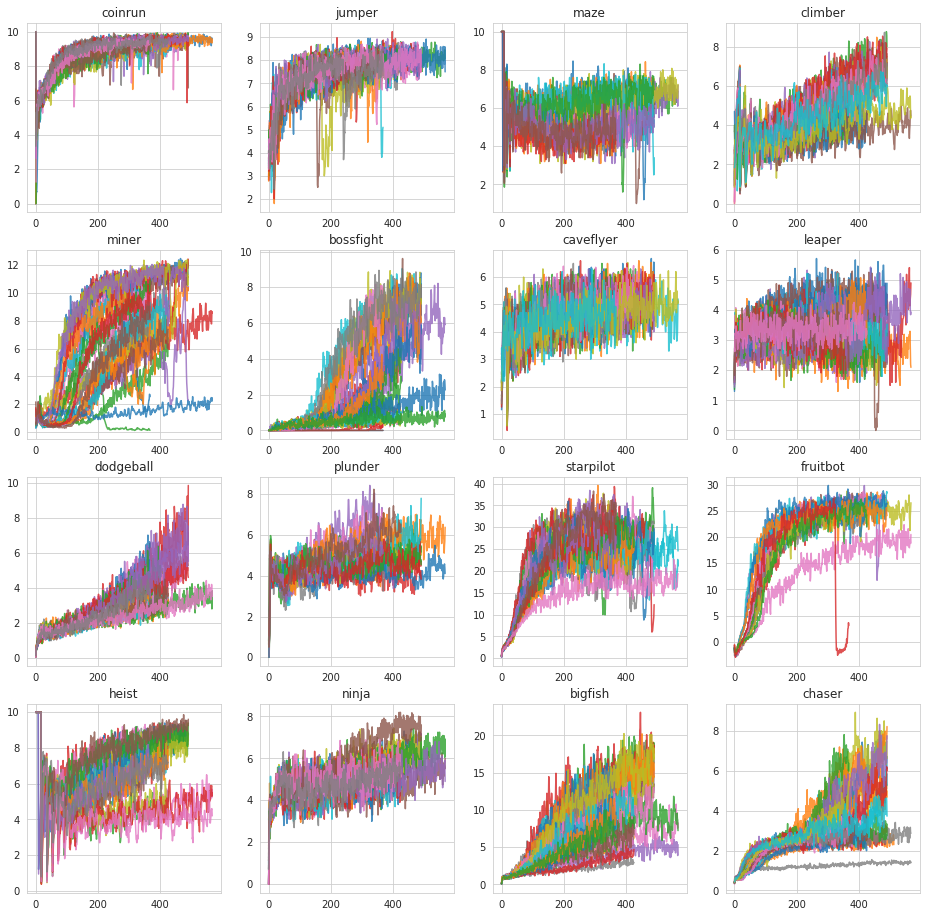

In [11]:
plot_runs(runs)

# Plot aggregate performance

In [12]:
class AggregateRun:
    def __init__(self, runs, field, value):
        self.runs = runs
        self.field = field
        self.value = value
        
    def for_env(self, env):
        return AggregateRun([r for r in self.runs if r.env == env], self.field, self.value)
            
    def __repr__(self):
        return f"{self.field}: {self.value}"
    
    def __len__(self):
        return len(self.runs)

def aggregate_runs(runs, aggregation_key):
    aggregate_runs = collections.defaultdict(list)
    for run in runs:
        if aggregation_key not in run.params:
            aggregate_runs["missing"].append(run)
        else:
            key = tuple(str(v) for v in run.params[aggregation_key].values)
            aggregate_runs[key].append(run)
    aggregate_runs = [AggregateRun(v, aggregation_key, k) for (k, v) in aggregate_runs.items()]
    return aggregate_runs

In [13]:
aggregation_key = "model_custom_options_data_augmentation_options_transforms"
agg_runs = aggregate_runs(runs, aggregation_key)

In [14]:
print(agg_runs)

[model_custom_options_data_augmentation_options_transforms: ('random_translate',), model_custom_options_data_augmentation_options_transforms: ('random_flip_up_down',), model_custom_options_data_augmentation_options_transforms: ('random_rotation',), model_custom_options_data_augmentation_options_transforms: ('random_flip_left_right',)]


In [15]:
def plot_agg_run(agg_run, ax, key):
    if len(agg_run) == 0:
        return
    min_len = min(len(r) for r in agg_run.runs)
    values = [r.results[key][:min_len] for r in agg_run.runs]
    if len(values) > 1:
        mean = np.mean(values, axis=0)
        values = np.array([np.array(v) for v in values])
        stderr = np.std(values, axis=0) / np.sqrt(len(values))
        ybelow = mean - stderr
        yabove = mean + stderr
    else:
        mean = np.array(values).reshape(-1)
        ybelow = None
        yabove = None
    
    x = range(len(mean))
    ax.plot(x, mean, label=f"{agg_run.value}")
    if ybelow is not None and yabove is not None:
        ax.fill_between(x, y1=yabove, y2=ybelow, label=f"{agg_run.value}", alpha=0.5)
    ax.set_title(agg_run.runs[0].env)

def plot_agg_runs(agg_runs, key="episode_reward_mean"):
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    for i, env_name in enumerate(ENV_NAMES):
        ax_row = i // 4
        ax_col = i % 4
        ax = axs[ax_row, ax_col]
        for agg_run in agg_runs:
            plot_agg_run(agg_run.for_env(env_name), ax, key=key)
        ax.legend()

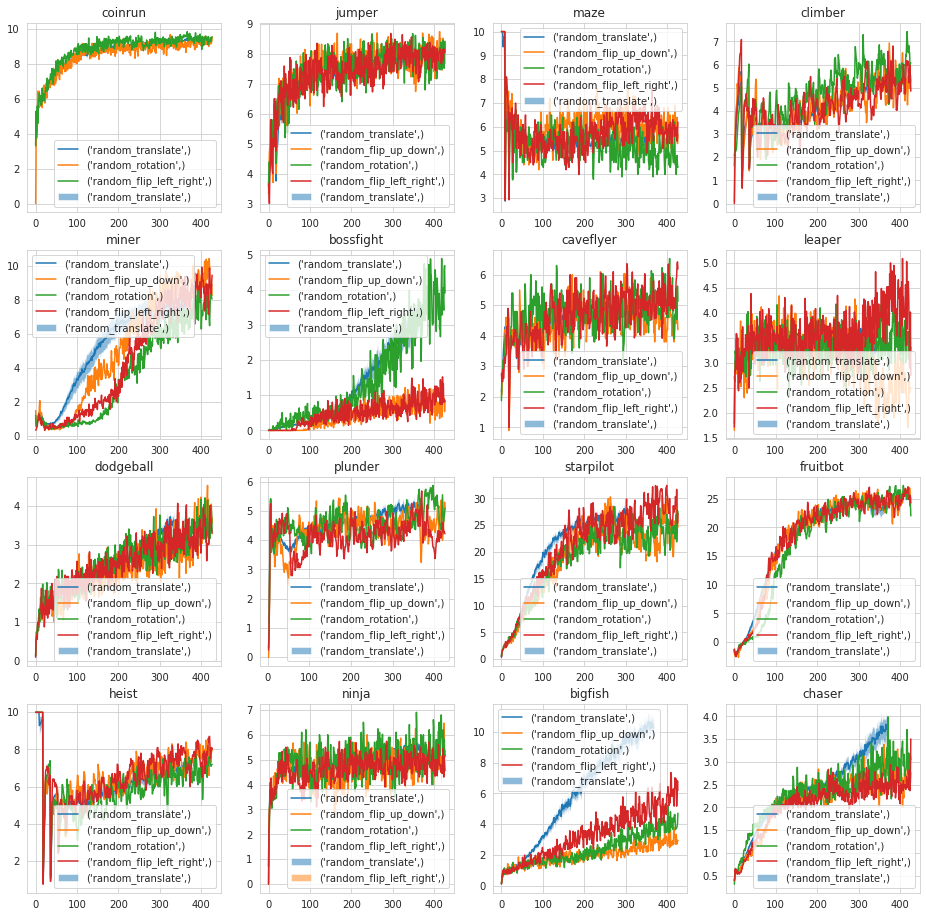

In [16]:
plot_agg_runs(agg_runs)

# Plot based on arbitrary subselect

In [17]:
def run_matches_pairs(run, pairs):
    for field, values in pairs.items():
        if field not in run.params or run.params[field].iloc[0] not in values:
            return False
    return True
    
def subselect_runs(runs, pairs):
    subselect = []
    for run in runs:
        if run_matches_pairs(run, pairs):
            subselect.append(run)
    return subselect

In [18]:
dropout_sub = subselect_runs(runs, {"model_custom_options_dropout_prob": [0.1]})
print(len(dropout_sub))

22


In [19]:
drac_weight_sub = subselect_runs(runs, {"model_custom_options_data_augmentation_options_mode_options_drac_drac_weight": [0.2]})
print(len(drac_weight_sub))

23


In [20]:
lr_sch_sub = subselect_runs(runs, {"lr_schedule": ["0_0.0005__4000000_0.0005__4000001_0.00025"]})
print(len(lr_sch_sub))

23


In [21]:
baseline_sub = subselect_runs(runs, 
                              {
                                  "lr": [0.0005],
                                  "num_sgd_iter": [2],
                                  "sgd_minibatch_size": [814],
                                  "entropy_coeff_schedule": ["0_0.01__4000000_0.005"]
                              })
print(len(baseline_sub))

16


In [22]:
bs_1628_sub = subselect_runs(runs, 
                              {
                                  "lr": [0.0005],
                                  "num_sgd_iter": [2],
                                  "sgd_minibatch_size": [1628],
                                  "entropy_coeff_schedule": ["0_0.01__4000000_0.005"]
                              })
print(len(bs_1628_sub))

77


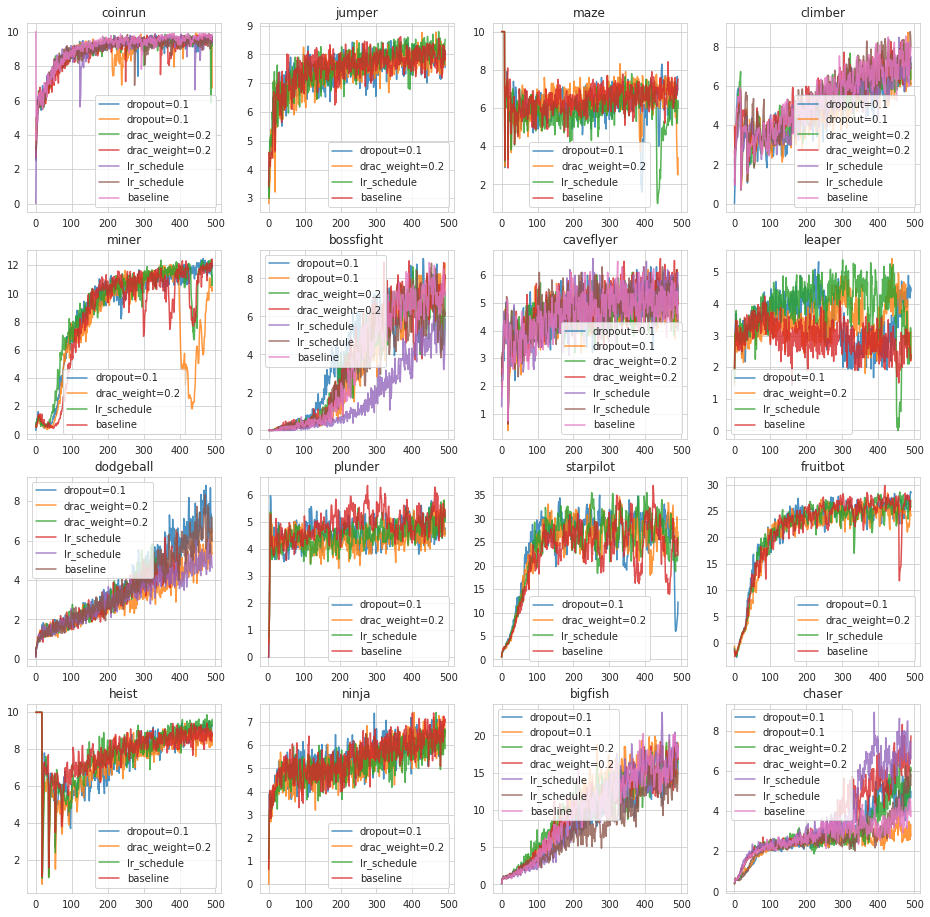

In [23]:
plot_runs(dropout_sub, label="dropout=0.1")
plot_runs(drac_weight_sub, label="drac_weight=0.2", make_figure=False)
plot_runs(lr_sch_sub, label="lr_schedule", make_figure=False)
plot_runs(baseline_sub, label="baseline", make_figure=False)

# Evaluation results

In [24]:
def plot_run_eval(run, ax, count, label, normalize):
    row = run.as_row()
    if "evaluation_episode_reward_mean" not in row:
        return 0
    y = row["evaluation_episode_reward_mean"].iloc[0]
    if normalize:
        min_r, blind_r, max_r = EASY_GAME_RANGES[run.env]
        y = (y - blind_r) / (max_r - blind_r)
    x = count
    ax.bar(x, y, width=0.5, alpha=0.7, label=f"{label}: {y:.4f}")
    ax.set_title(run.env)
    if label is not None:
        ax.legend()
    return 1
        
def plot_runs_eval(runs, ax_counts=None, label=None, make_figure=True, normalize=True):
    if ax_counts is None:
        ax_counts = collections.defaultdict(int)
    if make_figure:
        fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    else:
        fig = plt.gcf()
        axs = fig.get_axes()
        axs = np.reshape(axs, (4, 4))
    
    for run in runs:
        ax_index = ENV_NAMES.index(run.env)
        ax_row = ax_index // 4
        ax_col = ax_index % 4
        ax_count = ax_counts[ax_index]
        ax_counts[ax_index] += plot_run_eval(run, axs[ax_row, ax_col], ax_count, label=label, normalize=normalize)
    return ax_counts
        

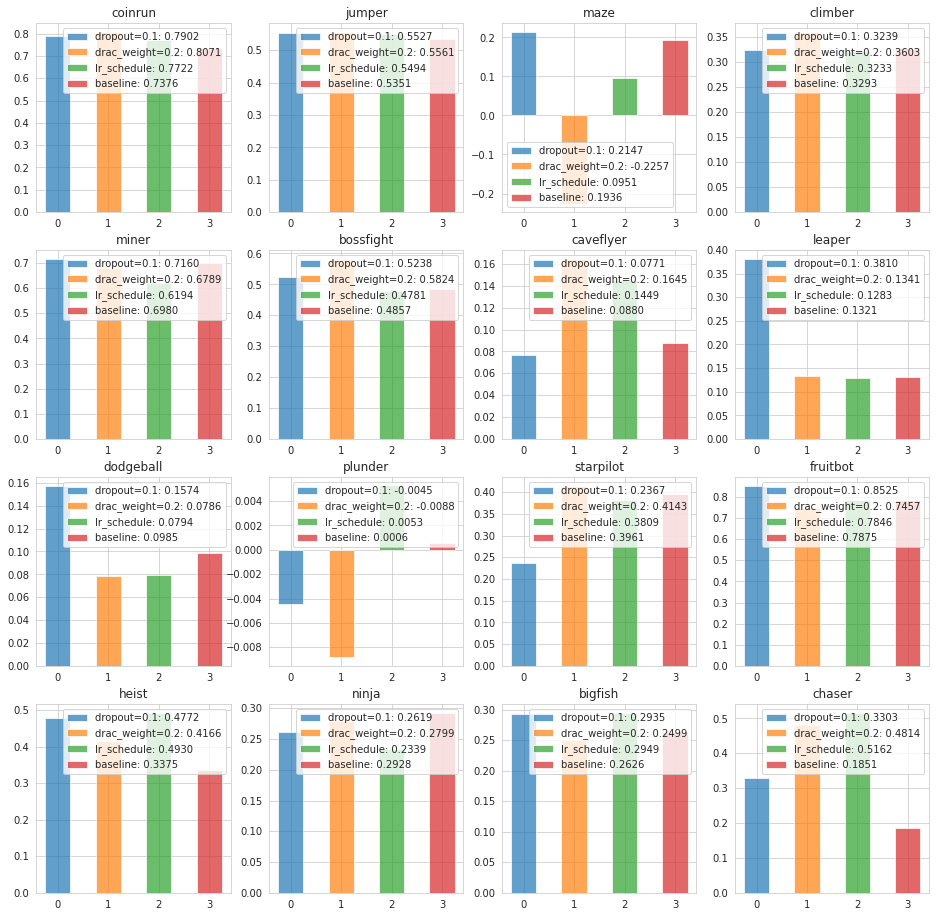

In [25]:
ax_counts = plot_runs_eval(dropout_sub, label="dropout=0.1")
ax_counts = plot_runs_eval(drac_weight_sub, ax_counts, label="drac_weight=0.2", make_figure=False)
ax_counts = plot_runs_eval(lr_sch_sub, ax_counts, label="lr_schedule", make_figure=False)
ax_counts = plot_runs_eval(baseline_sub, ax_counts, label="baseline", make_figure=False)

In [26]:
def get_eval_scores(runs):
    scores = []
    for run in runs:
        row = run.as_row()
        if "evaluation_episode_reward_mean" not in row:
            continue
        y = row["evaluation_episode_reward_mean"].iloc[0]
        min_r, blind_r, max_r = EASY_GAME_RANGES[run.env]
        y = (y - blind_r) / (max_r - blind_r)
        scores.append(y)
    return scores

In [27]:
def hist_eval_scores(runs, label, make_figure=True):
    if make_figure:
        plt.figure(figsize=(12,6))
    scores = get_eval_scores(runs)
    plt.hist(scores, bins=5, alpha=0.4, width=0.025, label=f"{label}: {np.mean(scores):.4f}")
    plt.legend()
    plt.title("histogram of normalized evaluation scores")

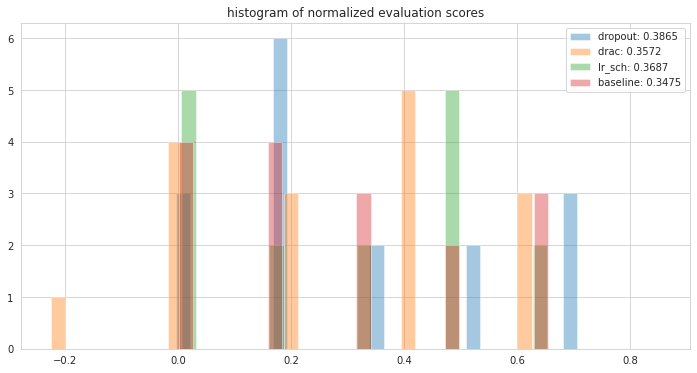

In [28]:
hist_eval_scores(dropout_sub, label="dropout")
hist_eval_scores(drac_weight_sub, label="drac", make_figure=False)
hist_eval_scores(lr_sch_sub, label="lr_sch", make_figure=False)
hist_eval_scores(baseline_sub, label="baseline", make_figure=False)

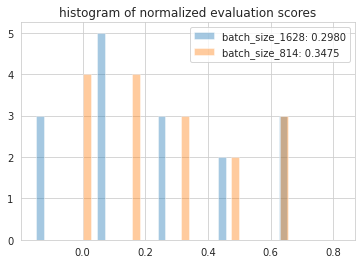

In [29]:
hist_eval_scores(bs_1628_sub, label="batch_size_1628", make_figure=False)
hist_eval_scores(baseline_sub, label="batch_size_814", make_figure=False)

#### If we select the best run for each env, what's the normalized score?

In [30]:
best_scores = collections.defaultdict(float)
for run in runs:
    row = run.as_row()
    if "evaluation_episode_reward_mean" not in row:
        continue
    y = row["evaluation_episode_reward_mean"].iloc[0]
    min_r, blind_r, max_r = EASY_GAME_RANGES[run.env]
    y = (y - blind_r) / (max_r - blind_r)
    best_scores[run.env] = max(best_scores[run.env], y)    

In [31]:
scores = []
for env, score in best_scores.items():
    scores.append(score)
    print(f"{env}: {score:.2f}")
print(f"\nmean: {np.mean(scores):.2f}")

climber: 0.36
ninja: 0.35
plunder: 0.05
heist: 0.49
leaper: 0.38
fruitbot: 0.85
bossfight: 0.58
coinrun: 0.81
chaser: 0.52
jumper: 0.57
miner: 0.72
dodgeball: 0.16
maze: 0.21
starpilot: 0.41
bigfish: 0.29
caveflyer: 0.16

mean: 0.43
